In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import sklearn.pipeline
from sklearn.compose import ColumnTransformer
from transforms import FourierTransform, MeanTransform

In [2]:
from dataset import HARDatasetCrops

## Data

### Features

In [3]:
dataset = HARDatasetCrops('motionsense-dataset/train', 256, 50, 50, metadata_file='motionsense-dataset/data_subjects_info.csv')

In [4]:
print('Dataset size:', len(dataset))

sample = dataset[0][0]
print('Datapoints shape:', sample.shape)

Dataset size: 4095
Datapoints shape: (256, 12)


Our dataset is composed of 5205 datapoints, each have shape `(256, 12)` because we have 12 signals of 256 samples each.

In [5]:
X_roll = np.array([sample[:,0] for sample, _, _ in dataset])
X_pitch = np.array([sample[:,1] for sample, _, _ in dataset])
X_yaw = np.array([sample[:,2] for sample, _, _ in dataset])
X_gx = np.array([sample[:,3] for sample, _, _ in dataset])
X_gy = np.array([sample[:,4] for sample, _, _ in dataset])
X_gz = np.array([sample[:,5] for sample, _, _ in dataset])
X_acc = np.array([np.linalg.norm(sample[:,6:9], axis=1) for sample, _, _ in dataset])
X_rot = np.array([np.linalg.norm(sample[:,9:12], axis=1) for sample, _, _ in dataset])

### Classes

The classes are the following:

In order to fit a `sklearn` model we should encode each class with a unique integer:

In [7]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(dataset.CLASSES.keys()));

In [8]:
y = label_encoder.transform([cls for _, cls, _ in dataset])

#### Train-test splitting

We will first "stack" our features.

In [10]:
X = np.hstack([X_roll,
               X_pitch,
               X_yaw,
               X_gx,
               X_gy,
               X_gz,
               X_acc,
               X_rot])

X.shape

(4095, 2048)

## Metadata

In [25]:
metadata = np.array([metadata for _, _, metadata in dataset])

In [26]:
metadata.shape

(4095, 4)

In [27]:
X = np.hstack([X, metadata])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### PCA feature reduction

In [29]:
features = ColumnTransformer([
    ("roll", roll_transform, slice(0, 256)),
    ("pitch", pitch_transform, slice(256, 512)),
    ("yaw", yaw_transform, slice(512, 768)),
    ("gravity-x", gx_transform, slice(768, 1024)),
    ("gravity-y", gy_transform, slice(1024, 1280)),
    ("gravity-z", gz_transform, slice(1280, 1536)),
    ("accelaration", acc_transform, slice(1536, 1792)),
    ("rotation", rot_transform, slice(1792, 2048)),
    ("metadata", "passthrough", slice(-4, X.shape[1]))
])

## Classification with k-Nearest Neighbours

In [35]:
import sklearn.neighbors

### Hyperparameter search

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [37]:
cv = ShuffleSplit(n_splits=5, test_size=0.15, random_state=0)

In [40]:
clf = sklearn.pipeline.Pipeline([
    ('features', features),
    ('normalize', sklearn.preprocessing.StandardScaler()),
    ('model', sklearn.neighbors.KNeighborsClassifier())
])

In [42]:
param_grid =  {
    'normalize': ['passthrough', sklearn.preprocessing.StandardScaler()],
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}

In [43]:
grid_search = GridSearchCV(clf, param_grid, cv=cv)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.15, train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('roll',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('meantransform',
                                                                                          MeanTransform())],
                                                                               

In [44]:
grid_search.best_params_

{'model__n_neighbors': 3,
 'model__weights': 'distance',
 'normalize': 'passthrough'}

In [45]:
grid_search.best_score_

0.9524271844660195

In [46]:
import pandas as pd

In [47]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [48]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.118917,0.008651,0.066947,0.007273,3,uniform,passthrough,"{'model__n_neighbors': 3, 'model__weights': 'u...",0.946602,0.966019,0.953883,0.961165,0.927184,0.950971,0.013592,2
1,0.115071,0.015295,0.171992,0.006856,3,uniform,"StandardScaler(copy=True, with_mean=True, with...","{'model__n_neighbors': 3, 'model__weights': 'u...",0.905340,0.927184,0.907767,0.905340,0.898058,0.908738,0.009781,12
2,0.107790,0.003365,0.031617,0.001735,3,distance,passthrough,"{'model__n_neighbors': 3, 'model__weights': 'd...",0.946602,0.966019,0.953883,0.963592,0.932039,0.952427,0.012338,1
3,0.102202,0.004006,0.137602,0.002551,3,distance,"StandardScaler(copy=True, with_mean=True, with...","{'model__n_neighbors': 3, 'model__weights': 'd...",0.905340,0.932039,0.905340,0.910194,0.893204,0.909223,0.012714,11
4,0.100526,0.002316,0.066087,0.004273,5,uniform,passthrough,"{'model__n_neighbors': 5, 'model__weights': 'u...",0.941748,0.961165,0.951456,0.953883,0.922330,0.946117,0.013418,4
5,0.105456,0.002584,0.165969,0.005849,5,uniform,"StandardScaler(copy=True, with_mean=True, with...","{'model__n_neighbors': 5, 'model__weights': 'u...",0.895631,0.912621,0.890777,0.912621,0.885922,0.899515,0.011133,13
6,0.106162,0.001714,0.035109,0.001629,5,distance,passthrough,"{'model__n_neighbors': 5, 'model__weights': 'd...",0.941748,0.963592,0.953883,0.956311,0.929612,0.949029,0.011989,3
7,0.112887,0.006884,0.157320,0.007439,5,distance,"StandardScaler(copy=True, with_mean=True, with...","{'model__n_neighbors': 5, 'model__weights': 'd...",0.898058,0.912621,0.888350,0.910194,0.883495,0.898544,0.011528,14
8,0.113407,0.011327,0.068870,0.005734,7,uniform,passthrough,"{'model__n_neighbors': 7, 'model__weights': 'u...",0.927184,0.956311,0.941748,0.956311,0.915049,0.939320,0.016246,7
9,0.109531,0.009070,0.170871,0.009922,7,uniform,"StandardScaler(copy=True, with_mean=True, with...","{'model__n_neighbors': 7, 'model__weights': 'u...",0.881068,0.907767,0.871359,0.890777,0.868932,0.883981,0.014186,15


In [49]:
print(classification_report(y_train, grid_search.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       1.00      1.00      1.00       236
         jog       1.00      1.00      1.00       265
         sit       1.00      1.00      1.00       663
         std       1.00      1.00      1.00       615
         ups       1.00      1.00      1.00       298
         wlk       1.00      1.00      1.00       666

    accuracy                           1.00      2743
   macro avg       1.00      1.00      1.00      2743
weighted avg       1.00      1.00      1.00      2743



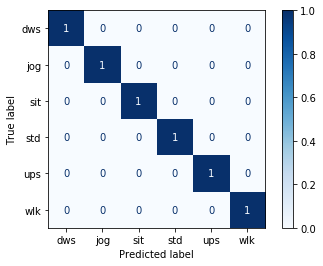

In [50]:
plot_confusion_matrix(grid_search, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [51]:
print(classification_report(y_test, grid_search.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.93      0.88      0.90       123
         jog       0.99      0.98      0.99       119
         sit       0.97      0.93      0.95       341
         std       0.92      0.96      0.94       285
         ups       0.91      0.92      0.92       138
         wlk       0.96      0.98      0.97       346

    accuracy                           0.95      1352
   macro avg       0.95      0.94      0.95      1352
weighted avg       0.95      0.95      0.95      1352



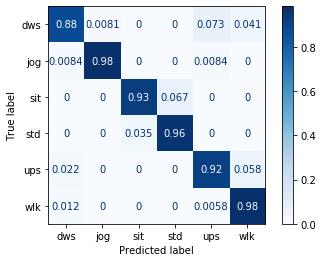

In [52]:
plot_confusion_matrix(grid_search, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

### Class-balancing

In [68]:
import imblearn.pipeline
import imblearn.over_sampling
import imblearn.under_sampling

In [69]:
clf = imblearn.pipeline.Pipeline([
    ('features', features),
    ('balancing', 'passthrough'),
    ('normalize', sklearn.preprocessing.StandardScaler()),
    ('model', sklearn.neighbors.KNeighborsClassifier())
])

In [70]:
sampling_strategy = {
    0: 300,
    1: 300,
    2: 300,
    3: 300,
    4: 300,
    5: 300,
}

In [72]:
param_grid =  {
    'balancing': ['passthrough', imblearn.over_sampling.SMOTE(random_state=1), imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_strategy, replacement=True, random_state=1)],
    'normalize': ['passthrough', sklearn.preprocessing.StandardScaler()],
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}

In [73]:
grid_search = GridSearchCV(clf, param_grid, cv=cv)

grid_search.fit(X_train, y_train)

/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: With under-sampling methods, the number of samples in a class should be less or equal to the original number of samples. Originally, there is 201 samples and 300 samples are asked.

  FitFailedWarning)
/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: With under-sampling methods, the number of samples in a class should be less or equal to the original number of samples. Originally, there is 207 samples and 300 samples are asked.

  FitFailedWarning)
/Users/sergio/PycharmProjects/MLEARN/venv/lib/python3.7/site-packages/sklearn/model_

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.15, train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('roll',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('meantransform',
                                                                                          MeanTransform())],
                                                                               

In [74]:
grid_search.best_params_

{'balancing': 'passthrough',
 'model__n_neighbors': 3,
 'model__weights': 'distance',
 'normalize': 'passthrough'}

In [75]:
grid_search.best_score_

0.9529126213592234

In [76]:
import pandas as pd

In [77]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [78]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_balancing,param_model__n_neighbors,param_model__weights,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.126054,0.018511,0.069158,0.006795,passthrough,3,uniform,passthrough,"{'balancing': 'passthrough', 'model__n_neighbo...",0.946602,0.966019,0.953883,0.963592,0.924757,0.950971,0.014836,4
1,0.115874,0.010991,0.174977,0.010494,passthrough,3,uniform,"StandardScaler(copy=True, with_mean=True, with...","{'balancing': 'passthrough', 'model__n_neighbo...",0.912621,0.934466,0.910194,0.915049,0.893204,0.913107,0.013152,31
2,0.119932,0.015438,0.037982,0.002715,passthrough,3,distance,passthrough,"{'balancing': 'passthrough', 'model__n_neighbo...",0.949029,0.966019,0.958738,0.961165,0.929612,0.952913,0.012898,1
3,0.121935,0.011731,0.151734,0.008182,passthrough,3,distance,"StandardScaler(copy=True, with_mean=True, with...","{'balancing': 'passthrough', 'model__n_neighbo...",0.907767,0.929612,0.922330,0.910194,0.893204,0.912621,0.012565,32
4,0.118378,0.010926,0.072287,0.004998,passthrough,5,uniform,passthrough,"{'balancing': 'passthrough', 'model__n_neighbo...",0.939320,0.961165,0.951456,0.953883,0.922330,0.945631,0.013610,11
5,0.107552,0.001861,0.170167,0.011516,passthrough,5,uniform,"StandardScaler(copy=True, with_mean=True, with...","{'balancing': 'passthrough', 'model__n_neighbo...",0.895631,0.917476,0.893204,0.905340,0.883495,0.899029,0.011549,33
6,0.100535,0.002356,0.035135,0.001765,passthrough,5,distance,passthrough,"{'balancing': 'passthrough', 'model__n_neighbo...",0.944175,0.963592,0.956311,0.956311,0.929612,0.950000,0.011950,7
7,0.115392,0.007671,0.159464,0.020134,passthrough,5,distance,"StandardScaler(copy=True, with_mean=True, with...","{'balancing': 'passthrough', 'model__n_neighbo...",0.890777,0.915049,0.898058,0.907767,0.883495,0.899029,0.011343,33
8,0.106099,0.001488,0.071647,0.004946,passthrough,7,uniform,passthrough,"{'balancing': 'passthrough', 'model__n_neighbo...",0.927184,0.953883,0.934466,0.956311,0.915049,0.937379,0.015760,25
9,0.117611,0.019274,0.173070,0.009351,passthrough,7,uniform,"StandardScaler(copy=True, with_mean=True, with...","{'balancing': 'passthrough', 'model__n_neighbo...",0.876214,0.910194,0.866505,0.888350,0.861650,0.880583,0.017395,36


In [79]:
print(classification_report(y_train, grid_search.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       1.00      1.00      1.00       236
         jog       1.00      1.00      1.00       265
         sit       1.00      1.00      1.00       663
         std       1.00      1.00      1.00       615
         ups       1.00      1.00      1.00       298
         wlk       1.00      1.00      1.00       666

    accuracy                           1.00      2743
   macro avg       1.00      1.00      1.00      2743
weighted avg       1.00      1.00      1.00      2743



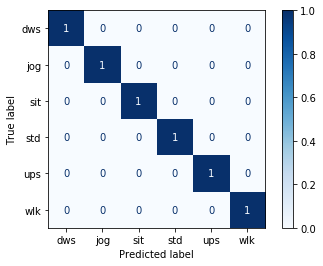

In [80]:
plot_confusion_matrix(grid_search, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [81]:
print(classification_report(y_test, grid_search.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.92      0.88      0.90       123
         jog       0.99      0.98      0.99       119
         sit       0.97      0.93      0.95       341
         std       0.92      0.96      0.94       285
         ups       0.91      0.91      0.91       138
         wlk       0.96      0.98      0.97       346

    accuracy                           0.95      1352
   macro avg       0.95      0.94      0.94      1352
weighted avg       0.95      0.95      0.95      1352



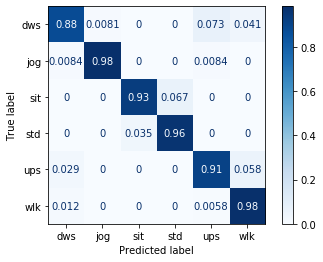

In [82]:
plot_confusion_matrix(grid_search, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")